In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s gdrive/'Team Drives'/'Data Mining Team'/ gdata

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pickle
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.externals import joblib
import matplotlib.pyplot as plt

In [5]:
#Read tokenized database
df = pickle.load(open("gdata/release/ModifiedData_wTokenized.pkl", 'rb'))
print("before: ", len(df))
#Oversample - same as train dataset
ros = RandomOverSampler(random_state=42)
dfType = df.dtypes.apply(lambda x: x.name).to_dict()
df_ros, _ = ros.fit_resample(df, df['Target'])
df = pd.DataFrame(df_ros, columns=df.columns).astype(dfType)
print("after: ", len(df))

before:  688328
after:  841568


In [6]:
df.head(3)

,date,reviewID,reviewerID,reviewContent,rating,usefulCount,coolCount,funnyCount,hotelID,Target,reviewLength,sentimentPolarity,sentimentSubjectivity,tokenized
0,6/8/2011,MyNjnxzZVTPq,IFTr6_6NI4CgCVavIL9k5g,Let me begin by saying that there are two kind...,5,18,11,28,tQfLGoolUMu2J0igcWcoZg,0,2249.0,0.025111,0.569762,let begin saying kinds people tokyo hotel 5 st...
1,8/30/2011,BdD7fsPqHQL73hwENEDT-Q,c_-hF15XgNhlyy_TqzmdaA,The only place inside the Loop that you can st...,3,0,3,4,tQfLGoolUMu2J0igcWcoZg,0,261.0,-0.046875,0.625000,the place inside loop stay 55/night also place...
2,6/26/2009,BfhqiyfC,CiwZ6S5ZizAFL5gypf8tLA,I have walked by the Tokyo Hotel countless tim...,5,12,14,23,tQfLGoolUMu2J0igcWcoZg,0,1239.0,0.172028,0.615385,i walked tokyo hotel countless times it remind...


In [0]:
#Train-test split
y = df['Target']
X = df.drop(['Target'], axis=1)

# Split the train data into X_train and y_train datasets in 80:20 ratio.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [0]:
#Train using XGBoost on sentiment attr
from xgboost import XGBClassifier
X_train_senti = X_train[['sentimentPolarity',	'sentimentSubjectivity', 'usefulCount', 'rating']]
X_test_senti = X_test[['sentimentPolarity',	'sentimentSubjectivity', 'usefulCount', 'rating']]
# fit model no training data
modelXGB = XGBClassifier(verbosity=3, random_state=42)
modelXGB.fit(X_train_senti, y_train)

# make predictions for test data
y_pred = modelXGB.predict(X_test_senti)

from sklearn import metrics

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.52      0.54     84404
           1       0.56      0.62      0.59     83910

   micro avg       0.57      0.57      0.57    168314
   macro avg       0.57      0.57      0.57    168314
weighted avg       0.57      0.57      0.57    168314



In [0]:
# prepare data 
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_idf = vectorizer.fit_transform(X_train['tokenized'])
X_test_idf = vectorizer.transform(X_test['tokenized'])
X_train_senti = X_train[['sentimentPolarity',	'sentimentSubjectivity', 'usefulCount', 'rating']]
X_test_senti = X_test[['sentimentPolarity',	'sentimentSubjectivity', 'usefulCount', 'rating']]

In [15]:
# SVM
from sklearn.utils import resample
X_train_low, y_train_low = X_train_idf, y_train#resample(X_train_idf, y_train, n_samples=100000, replace=True, random_state=0)
# print(len(X_train_low))
# print(len(y_train_low))
X_test_low, y_test_low = X_test_idf, y_test#resample(X_test_idf, y_test, n_samples=20000, replace=True, random_state=0)

# fit model no training data
from sklearn.svm import LinearSVC
svm = LinearSVC(random_state=0, tol=1e-5)
svm.fit(X_train_low, y_train_low) 

# make predictions for test data
y_pred = svm.predict(X_test_low)

from sklearn import metrics
print(metrics.classification_report(y_test_low, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.68      0.71     84404
           1       0.70      0.75      0.73     83910

   micro avg       0.72      0.72      0.72    168314
   macro avg       0.72      0.72      0.72    168314
weighted avg       0.72      0.72      0.72    168314



In [0]:
import pickle
# pickle.dump(svm, open("gdata/release/svm.pkl", "wb"))

In [0]:
import pickle
# svm = pickle.load(open("gdata/release/svm.pkl", "rb"))

[-0.05846469 -0.45031966  0.35293196 ... -0.41500207  0.59132267
 -0.70779641]
0.7879633254922521


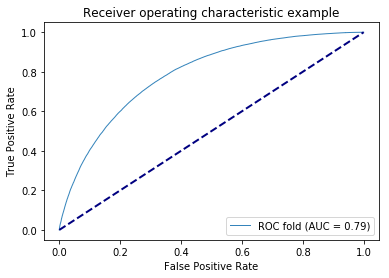

In [17]:
# ROC

probs = svm.decision_function(X_test_idf)
print(probs)

# keep probabilities for the positive outcome only
# print(probs)  #= probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
# fpr, tpr, thresholds = roc_curve(y_test_low, probs) #fpr, tpr, thresholds = roc_curve(y_test_low, y_pred)
# # plt.figure(1)
# # plt.plot([0, 1], [0, 1], 'k--')
# # plt.plot(fpr, tpr, label='RT + LR')
# # plt.xlabel('False positive rate')
# # plt.ylabel('True positive rate')
# # plt.title('ROC curve')
# # plt.legend(loc='best')
# # plt.show()
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.plot(fpr, tpr, lw=1, alpha=0.9,
          label='ROC fold (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC


svm = LinearSVC(random_state=0, tol=1e-5)
clf_svm_pipe = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf-svm', svm)])
params_svm = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False)}

# text_clf_svm = text_clf_svm.fit(X_train['reviewContent'], y_train)

gs_clf_svm = GridSearchCV(clf_svm_pipe, params_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(X_train['reviewContent'], y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [0]:
print(gs_clf.best_score_)
print(gs_clf.best_params_)

In [0]:
y_pred

array([0, 0, 1, ..., 0, 1, 0])

NotFittedError: ignored

In [0]:
from sklearn.utils import resample
X_train_low, y_train_low = X_train_senti, y_train#resample(X_train_idf, y_train, n_samples=100000, replace=True, random_state=0)
# print(len(X_train_low))
# print(len(y_train_low))
X_test_low, y_test_low = X_test_senti, y_test#resample(X_test_idf, y_test, n_samples=20000, replace=True, random_state=0)

# fit model no training data
from sklearn.svm import LinearSVC
svm = LinearSVC(random_state=0, tol=1e-5)
svm.fit(X_train_low, y_train_low) 

# make predictions for test data
y_pred = svm.predict(X_test_low)

from sklearn import metrics
print(metrics.classification_report(y_test_low, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.11      0.18     84404
           1       0.51      0.92      0.65     83910

   micro avg       0.51      0.51      0.51    168314
   macro avg       0.54      0.52      0.42    168314
weighted avg       0.55      0.51      0.42    168314



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences



673254
168314


In [0]:
#Load already trained model. The model is a pipeline, so we are operating on reviewContent and not tokenized.
model = joblib.load('gdata/release/Naive_Bayes_GS.skmodel')

pred_prob = model.predict_proba(X_test['reviewContent'])

In [0]:
import numpy as np
pred_prob

0.5

0.864004944840516


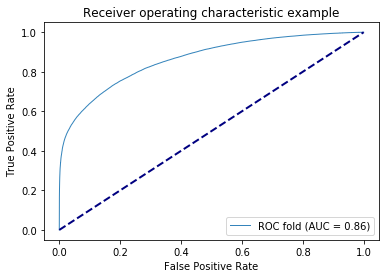

In [0]:
fpr, tpr, thresholds = (y_test, [x[1] for x in pred_prob], pos_label=1)


roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.plot(fpr, tpr, lw=1, alpha=0.9,
          label='ROC fold (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()